In [115]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines
import pandas as pd
import time, os, sys, pickle
import seaborn as sns
from tqdm import tqdm
import svgutils.compose as sc
import IPython.display as ip
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# import bptt_rnn as bp  # RNN, learning algorithm, loss function etc
import bptt_rnn_mtl as bpm
import plot_routines as pr  # plotting functions & directly related
import plot_routines_mtl as prm
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

pr.set_fontsize(12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:

pr.set_fontsize(12)

In [336]:
# Data parameters dictionary
d_dict = { 'n_total': 1000,  # total number of data sequences
         'ratio_train': 0.8,
         'ratio_exp': 0.5,  # probabilities of switching between alpha nd beta
         'noise_scale': 0.15,
         't_delay': 2,
         't_stim': 2}

## Set training parameters:
t_dict = {}
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
t_dict['learning_rate'] = 0.002  # algorithm lr
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 30  # training epochs
t_dict['l1_param'] = 1e-3  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 


In [337]:
tmp0, tmp1 = bpm.generate_synt_data_general(n_total=d_dict['n_total'], t_delay=d_dict['t_delay'], t_stim=d_dict['t_stim'], 
                                        ratio_train=d_dict['ratio_train'], ratio_exp=d_dict['ratio_exp'],
                                        noise_scale=d_dict['noise_scale'], late_s2=False,
                                        nature_stim='onehot', task='dmc')
                    
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

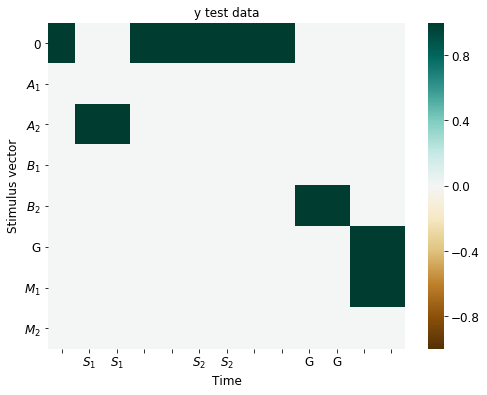

In [51]:
ax_true = plt.subplot(111)
k = np.where(labels_test == '22')[0]
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
prm.plot_example_trial(true_data.numpy(), ax=ax_true,
                     vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

In [55]:
y_test[:, np.array([11, 12]), :][:, :, 6:].sum(2).mean()

tensor(1.)

In [82]:
rnn = bpm.RNN_MTL(task='pred_dmc', nature_stim='onehot', n_nodes=t_dict['n_nodes'])  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

cpu


In [83]:
rnn = bpm.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                        x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test,
                        verbose=0, late_s2=False, use_gpu=False, simulated_annealing=False,
                        ratio_exp_array=None, save_state=True)

Epoch 29/30. Train loss: 0.797421: 100%|██████████| 30/30 [02:48<00:00,  5.62s/it]     


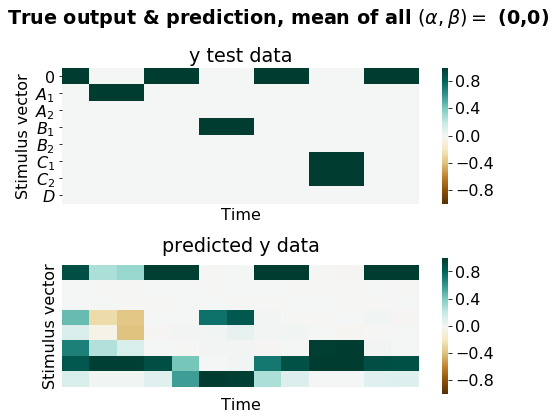

In [302]:
## Plot example test sample & prediction
k = np.where(labels_test == '00')[0]
# print(f'Trial type: {labels_test[k]}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
            xticklabels=[], vmin=-1, c_map='BrBG')
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
# if rnn.lin_output.out_features > rnn.n_stim:
pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
                      yticklabels=[],
               xticklabels=[], vmin=-1, c_map='BrBG')  # average if multiple samples
# else:
#     pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
#                xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

Trial type: ['11']
pred: 0.709687864780426
dmc: 0.07160422839224338


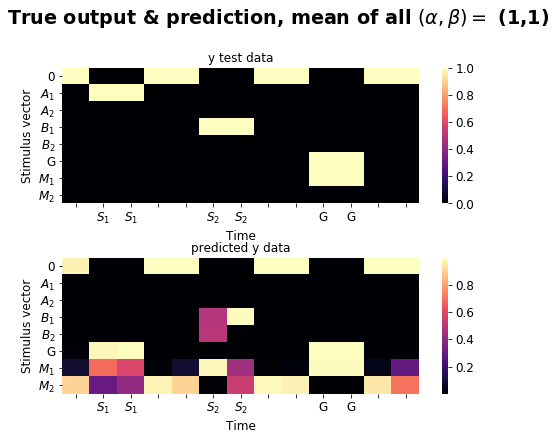

In [339]:
# i_rnn += 1
i_rnn =0
folder_rnn = '/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/'
filename = os.listdir(folder_rnn)[i_rnn]
rnn = ru.load_rnn(os.path.join(folder_rnn, filename))
# print(filename)


## Plot example test sample & prediction
k = np.where(labels_test == '11')[0]
print(f'Trial type: {np.unique(labels_test[k])}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]

# part_spec_loss = bpm.specialisation_loss(y_est=pred, y_true=true_data, model=rnn)
# part_spec_loss = part_spec_loss.detach().numpy()
# print('part spec loss', part_spec_loss)

if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
prm.plot_example_trial(true_data.numpy(), ax=ax_true)
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
prm.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred)  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

for key in ['pred', 'dmc']:
    if key in rnn.test_loss_split.keys():
        print(f'{key}:', np.mean(rnn.test_loss_split[key][-5:]))

# full_pred = bpm.compute_full_pred(input_data=x_test, model=rnn)  # computed forward predictions
# spec_loss = bpm.specialisation_loss(y_est=full_pred, y_true=y_test, model=rnn)
# spec_loss = spec_loss.detach().numpy()
# print('spec loss', spec_loss)
# print('reg loss', bpm.regularisation_loss(model=rnn))

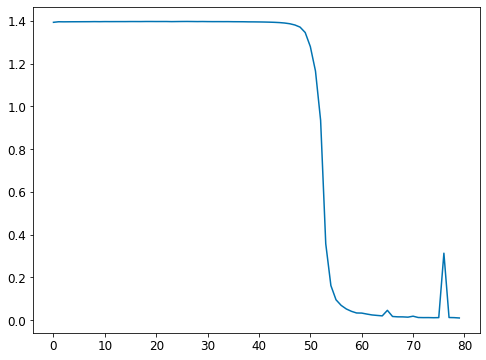

In [340]:
plt.plot(rnn.test_loss_split['dmc'])

In [341]:
rnn.info_dict

{'converged': False,
 'task': 'pred_dmc',
 'output_nonlin_pred': 'softmax',
 'output_nonlin_spec': 'softmax_relu',
 'pred_loss_function': 'cross_entropy',
 'nature_stim': 'onehot',
 'spec_task_name': 'dmc',
 'n_total': 1000,
 'ratio_train': 0.8,
 'ratio_exp': 0.5,
 'noise_scale': 0.15,
 't_delay': 2,
 't_stim': 2,
 'n_nodes': 20,
 'learning_rate': 0.002,
 'bs': 1,
 'n_epochs': 80,
 'check_conv': False,
 'conv_rel_tol': 0.0005,
 'l1_param': 0.001,
 'type_task': 'dmc',
 'train_task': 'pred_spec',
 'late_s2': False,
 'simulated_annealing': False,
 'trained_epochs': 80,
 'timestamp': '2021-05-13-2304'}

In [99]:
rnn = ru.load_rnn('models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2134.data')
# rnn.load_state_dict(rnn.saved_states_dict[30])
# rnn.saved_states_dict[10]['lin_output.bias']

cpu


12it [00:00, 55492.45it/s]
12it [00:00, 953.29it/s]


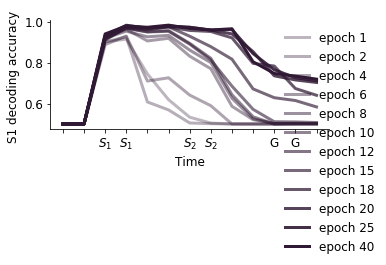

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
tmp = prm.plot_autotemp_s1_different_epochs(ax=ax, autotemp_dec_dict=tmp)

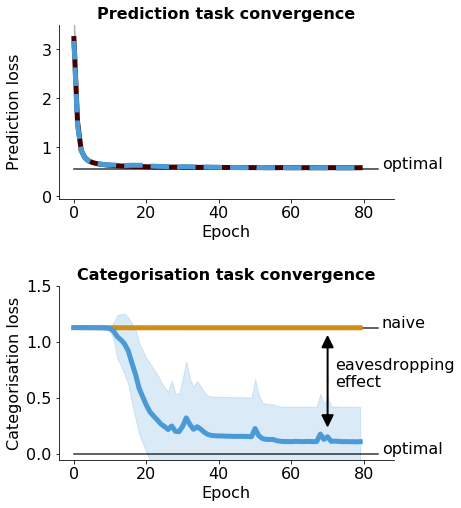

In [92]:

pr.set_fontsize(16)

fig, ax = plt.subplots(2, 1, figsize=(6, 8), gridspec_kw={'hspace': 0.5})
optimal_pred = -0.25 * (3 * np.log(0.75) + np.log(0.25))
ax[0].plot([0, 84], [optimal_pred, optimal_pred], c='k', alpha=0.8)
prm.plot_effect_eavesdropping_learning(task='dmc', ratio_exp_str='7525', nature_stim='onehot',
                                       sparsity_str='1e-03', ax=ax[0], plot_legend=False,
                                       plot_std=True, plot_indiv=False, plot_spec=False)
ax[0].text(s='optimal', x=85, y=optimal_pred)
ax[0].set_ylabel('Prediction loss')
ax[0].set_title('Prediction task convergence', fontdict={'weight': 'bold'})
# plt.savefig('figures/nips/fig1_prediction_task.svg', bbox_inches='tight')


optimal_cat = 0
naive_cat = 2 * optimal_pred
ax[1].plot([0, 84], [optimal_cat, optimal_cat], c='k', alpha=0.8)
ax[1].plot([0, 84], [naive_cat, naive_cat], c='k', alpha=0.8)
prm.plot_effect_eavesdropping_learning(task='dmc', ratio_exp_str='7525', nature_stim='onehot',
                                       sparsity_str='1e-03', ax=ax[1], plot_legend=False,
                                       plot_std=True, plot_indiv=False, plot_pred=False)
ax[1].text(s='optimal', x=85, y=optimal_cat)
ax[1].text(s='naive', x=85, y=naive_cat)
plt.arrow(70, 0.65, 0, 0.4, head_width=3, head_length=0.1, linewidth=1.5, 
          color='k', length_includes_head=True)
plt.arrow(70, 0.65, 0, -0.4, head_width=3, head_length=0.1, linewidth=1.5, 
          color='k', length_includes_head=True)
ax[1].text(s='eavesdropping\neffect', x=72, y=0.6)
ax[1].set_ylabel('Categorisation loss')
ax[1].set_title('Categorisation task convergence', fontdict={'weight': 'bold'})

fig.align_ylabels(axs=[ax[0], ax[1]])

plt.savefig('figures/nips/fig1_prediction_and_categorisation_task.svg', bbox_inches='tight')

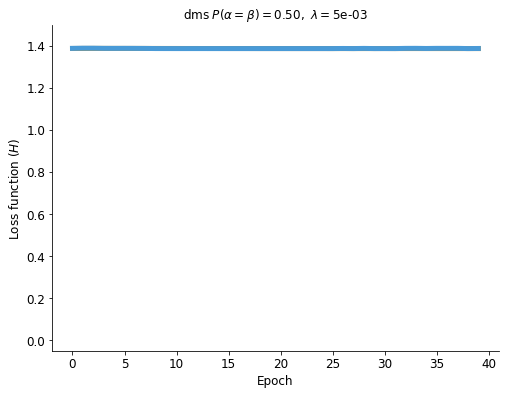

In [408]:
prm.plot_effect_eavesdropping_learning(task='dms', ratio_exp_str='5050', nature_stim='onehot',
                                       sparsity_str='5e-03', ax=None, plot_legend=False,
                                       plot_std=False, plot_indiv=True, plot_pred=False)

80


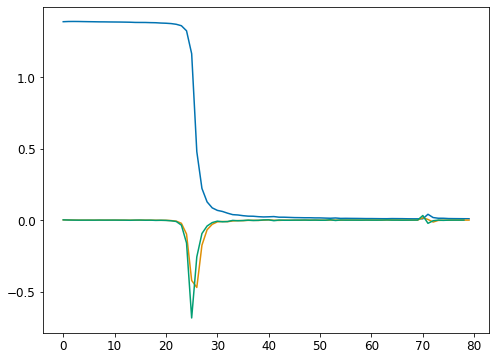

In [82]:
plt.plot(rnn.test_loss_split['dmc'])
plt.plot(np.gradient(rnn.test_loss_split['dmc']))
plt.plot(np.diff(rnn.test_loss_split['dmc']))
print(len(np.gradient(rnn.test_loss_split['dmc'])))

list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-05/pred_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-05/dmc_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-05/pred_dmc/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-04/pred_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-04/dmc_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-04/pred_dmc/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-03/pred_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-03/dmc_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-03/pred_dmc/
list rnns shortened for models/7525/dms_task/periodic/sparsity_1e-05/pred_only/
list rnns shortened for models/7525/dms_task/periodic/sparsity_1e-05/dms_only/
list rnns shortened for models/7525/dms_task/periodic/sparsity_1e-05/pred_dms/
list rnns shortened for models/7525/dms_task/per

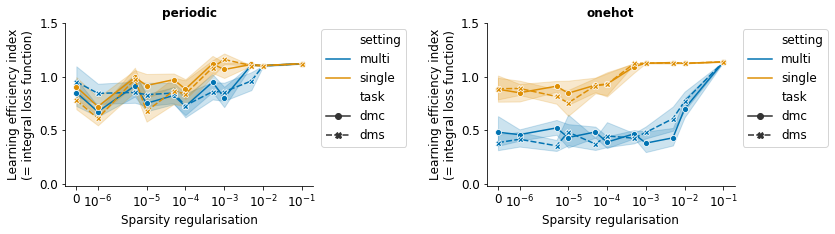

In [406]:
df = prm.plot_learning_efficiency(plot_difference=False, method='integral', task_list=['dmc', 'dms'])

In [194]:
tmp = df[np.logical_and(df['nature_stim'] == 'onehot', df['task'] == 'dmc')].groupby(['sparsity', 'setting']).std()
tmp.iloc[10]

learning_eff    0.16623
Name: (0.0001, multi), dtype: float64

list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-05/pred_only/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-05/dmrc_only/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-05/pred_dmrc/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-04/pred_only/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-04/dmrc_only/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-04/pred_dmrc/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-03/pred_only/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-03/dmrc_only/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-03/pred_dmrc/
list rnns shortened for models/7525/dmrs_task/periodic/sparsity_1e-05/pred_only/
list rnns shortened for models/7525/dmrs_task/periodic/sparsity_1e-05/dmrs_only/
list rnns shortened for models/7525/dmrs_task/periodic/sparsity_1e-05/pred_dmrs/
list rnns shortened for mode

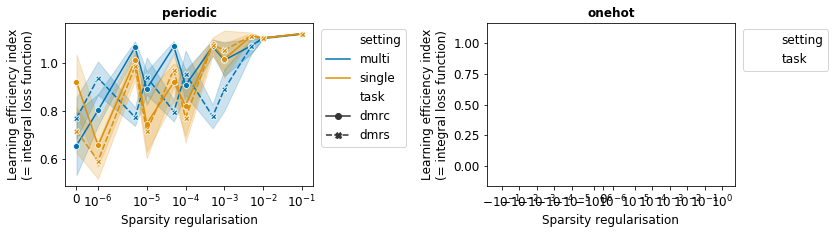

In [21]:
df = prm.plot_learning_efficiency(plot_difference=False, method='integral', task_list=['dmrc', 'dmrs'])

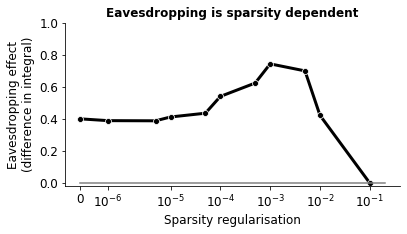

In [219]:
df = prm.plot_learning_efficiency(plot_difference=True, method='integral', task_list=['dmc'], nature_stim_list=['onehot'])

In [202]:
df

,task,nature_stim,loss_comp,setting,learning_eff,sparsity


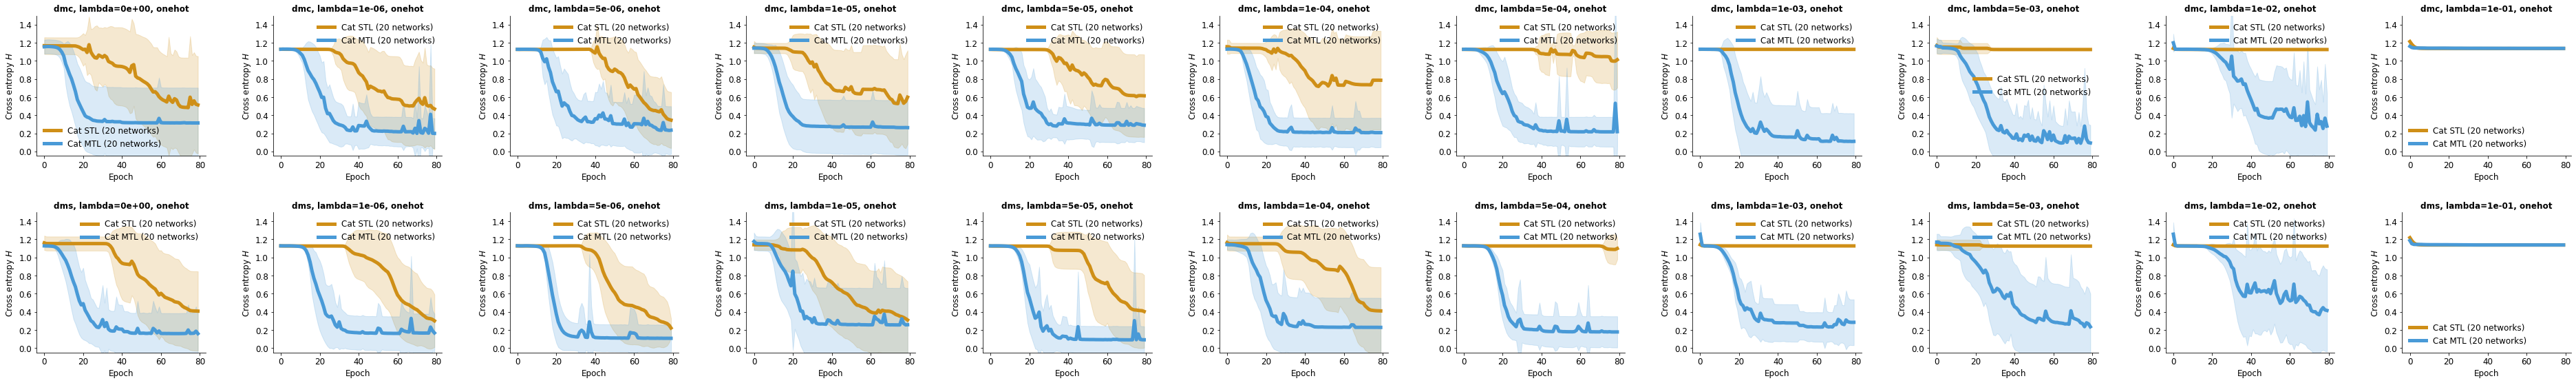

In [124]:
sparsity_str_arr = ['0e+00', '1e-06', '5e-06', '1e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03', '1e-02', '1e-01']
task_list = ['dmc', 'dms']
# sparsity_str_arr = ['0e+00', '5e-06', '1e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03']
fig, ax = plt.subplots(len(task_list), len(sparsity_str_arr), figsize=(len(sparsity_str_arr) * 6, len(task_list) *4.5), 
                       gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
pr.set_fontsize(12)
for i_spars, spars in enumerate(sparsity_str_arr):
    for i_task, task in enumerate(task_list):
        for i_nat, nat in enumerate(['onehot']):
            prm.plot_effect_eavesdropping_learning(task=task, ratio_exp_str='7525', 
                                                   sparsity_str=spars, nature_stim=nat,
                                                   ax=ax[i_task + 2 * i_nat][i_spars],
                                                   plot_std=True, plot_indiv=False, plot_pred=False,
                                                   plot_legend=True)#(i_spars == 0 and i_task ==0 and i_nat == 0 and False))
            ax[i_task + 2 * i_nat][i_spars].set_title(f'{task}, lambda={spars}, {nat}', 
                                                     fontdict={'weight': 'bold'})
# plt.savefig('figures/learning_efficiency_dmc_dms_periodic_only.pdf', bbox_inches='tight')        

In [12]:
(x_train, y_train, x_test, y_test), (labels_train, labels_test) = bpm.generate_synt_data_general(n_total=1000, t_delay=2, t_stim=2,
                               ratio_train=0.8, ratio_exp=0.75,
                               noise_scale=0.05, late_s2=False,
                               nature_stim='onehot', task='dmc')

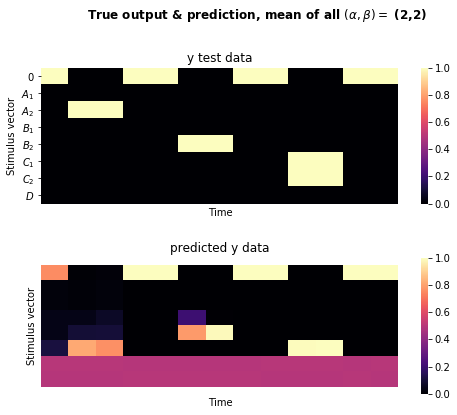

In [18]:
i_rnn =0
folder_comb = '/home/thijs/repos/rotation/models/sweep_n_nodes/7525/dmc_task/onehot/sparsity_5e-03/25_nodes/pred_only'
filename = os.listdir(folder_comb)[i_rnn]
rnn = ru.load_rnn(os.path.join(folder_comb, filename))

## Plot example test sample & prediction
k = np.where(labels_test == '22')[0]
# print(f'Trial type: {labels_test[k]}')
pred = bpm.compute_full_pred(x_test[k,:,:], model=rnn)  # computed forward predictions

plt.rcParams['figure.figsize'] = (8,6 )
plt.subplots_adjust(hspace=0.4)
ax_true = plt.subplot(211)
true_data = y_test[k, :, :]
if type(k) != int and len(k) > 1:  # if multiple samples; average
    true_data = true_data.mean(0)
pr.plot_example_trial(true_data.numpy(), ax=ax_true,
            xticklabels=[])
ax_true.set_title("y test data"); #ax_true.set_ylabel('True data')

ax_pred = plt.subplot(212)
# if rnn.lin_output.out_features > rnn.n_stim:
pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
                      yticklabels=[],
               xticklabels=[])  # average if multiple samples
# else:
#     pr.plot_example_trial(pred.mean(0).detach().numpy(), ax=ax_pred,
#                xticklabels=double_time_labels_blank[1:])  # average if multiple samples
ax_pred.set_title("predicted y data"); #ax_pred.set_ylabel("Predictions");

plt.suptitle(r"True output & prediction, mean of all $(\alpha, \beta) =$ (" + labels_test[k][0][0] + ',' + labels_test[k][0][1] + ')', 
             weight='bold', y=1.02);
# plt.savefig('figures/prediction_unexpected.pdf', bbox_inches='tight')

In [271]:
ru.count_datasets_sparsity_sweep()

,sparsity,sparsity_str,dmrc_periodic,dmc_periodic,dmc_onehot,dms_periodic,dms_onehot,dmrs_periodic
0,0.000000,0e+00,20,20,20,20,20,20
1,0.000001,1e-06,20,20,20,20,20,20
2,0.000005,5e-06,20,20,20,20,20,20
3,0.000010,1e-05,30,30,20,30,20,30
4,0.000050,5e-05,20,20,20,20,20,20
5,0.000100,1e-04,30,30,20,30,20,30
6,0.000500,5e-04,20,20,20,20,20,20
7,0.001000,1e-03,30,30,20,30,20,30
8,0.005000,5e-03,20,20,20,20,20,20
9,0.010000,1e-02,20,20,20,20,20,20


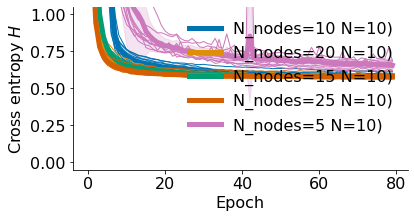

In [79]:
prm.plot_n_nodes_convergence(plot_indiv=True,
  parent_folder='/home/thijs/repos/rotation/models/sweep_n_nodes/7525/dms_task/onehot/sparsity_1e-04/')

0.00010334649564653764 mtl stl
0.016880932087628427 late s2
8.857457687863547e-05 mtl stl


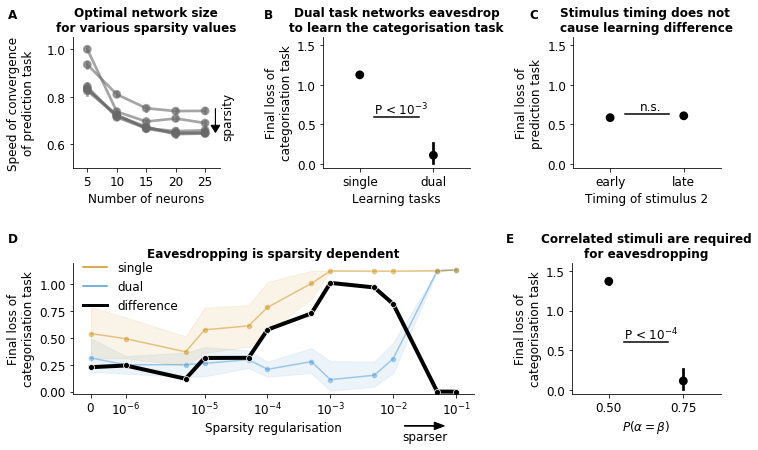

In [129]:
fig = plt.figure(constrained_layout=False, figsize=(9, 5.5))
gs_top = fig.add_gridspec(ncols=3, nrows=1, bottom=0.62, top=0.95, left=0, right=1, wspace=0.7)
gs_bottom_l = fig.add_gridspec(ncols=1, nrows=1, bottom=0.05, top=0.38, left=0, right=0.62, wspace=0.7)
gs_bottom_r = fig.add_gridspec(ncols=1, nrows=1, bottom=0.05, top=0.38, left=0.77, right=1, wspace=0.7)

ax_top, ax_bottom = {}, {}
for ii in range(3):
    ax_top[ii] = fig.add_subplot(gs_top[ii])
ax_bottom_r = fig.add_subplot(gs_bottom_r[0])
ax_bottom_l = fig.add_subplot(gs_bottom_l[0])
# for ii in range(2):
#     ax_bottom[ii] = fig.add_subplot(gs_bottom[ii])
prm.plot_n_nodes_sweep_multiple(method='integral', ax=ax_top[0])
prm.plot_stl_mtl_comparison(method='final_loss', ax=ax_top[1])
prm.plot_late_s2_comparison(method='final_loss', ax=ax_top[2])
prm.plot_7525_5050_comparison(method='final_loss', ax=ax_bottom_r)

df = prm.plot_learning_efficiency(plot_difference=False, method='final_loss', task_list=['dmc'],
                                  nature_stim_list=['onehot'], ax=ax_bottom_l, indicate_sparsity=False)
df = prm.plot_learning_efficiency(plot_difference=True, method='final_loss', task_list=['dmc'],
                                  nature_stim_list=['onehot'], ax=ax_bottom_l, indicate_sparsity=True,
                                  plot_custom_legend=True)

ax_top[0].text(s='A', x=-2.7, y=1.13, fontdict={'weight': 'bold'})
ax_top[0].text(s='B', x=6, y=1.13, fontdict={'weight': 'bold'})
ax_top[0].text(s='C', x=15, y=1.13, fontdict={'weight': 'bold'})
ax_top[0].text(s='D', x=-2.7, y=0.19, fontdict={'weight': 'bold'})
ax_top[0].text(s='E', x=14.2, y=0.19, fontdict={'weight': 'bold'})

fig.align_ylabels(axs=[ax_top[0], ax_bottom_l])
fig.align_ylabels(axs=[ax_top[2], ax_bottom_r])

# plt.savefig('figures/nips/fig2-homework.pdf', bbox_inches='tight')

list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-05/pred_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-05/dmc_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-05/pred_dmc/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-04/pred_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-04/dmc_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-04/pred_dmc/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-03/pred_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-03/dmc_only/
list rnns shortened for models/7525/dmc_task/periodic/sparsity_1e-03/pred_dmc/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-05/pred_only/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-05/dmrc_only/
list rnns shortened for models/7525/dmrc_task/periodic/sparsity_1e-05/pred_dmrc/
list rnns shortened for models/7525/dmrc_ta

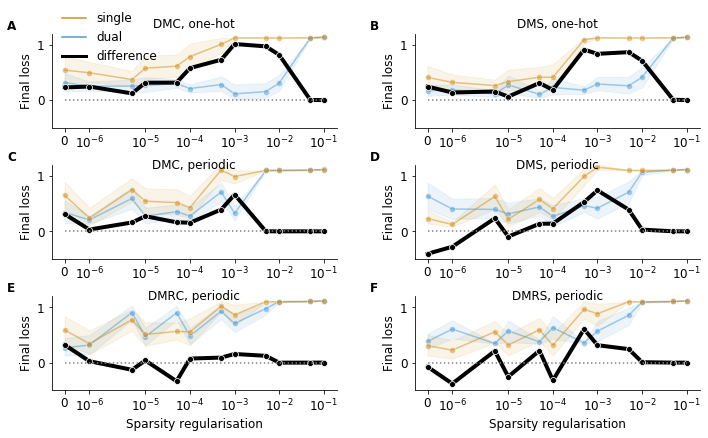

In [135]:
fig = plt.figure(constrained_layout=False, figsize=(9, 5.5))
gs_left = fig.add_gridspec(ncols=1, nrows=3, bottom=0.05, top=0.95, left=0, right=0.44, wspace=0.7, hspace=0.4)
gs_right = fig.add_gridspec(ncols=1, nrows=3, bottom=0.05, top=0.95, left=0.56, right=1, wspace=0.7, hspace=0.4)

ax_left, ax_right = {}, {}
for ii in range(3):
    ax_left[ii] = fig.add_subplot(gs_left[ii])
    ax_right[ii] = fig.add_subplot(gs_right[ii])
    
method = 'final_loss'    

for bool_diff in [False, True]:
    df = prm.plot_learning_efficiency(plot_difference=bool_diff, method=method, 
                                      task_list=['dmc'], nature_stim_list=['onehot'], ax=ax_left[0],
                                      plot_custom_legend=bool_diff)
    df = prm.plot_learning_efficiency(plot_difference=bool_diff, method=method, 
                                      task_list=['dmc'], nature_stim_list=['periodic'], ax=ax_left[1])
    df = prm.plot_learning_efficiency(plot_difference=bool_diff, method=method, 
                                      task_list=['dmrc'], nature_stim_list=['periodic'], ax=ax_left[2])

    df = prm.plot_learning_efficiency(plot_difference=bool_diff, method=method, 
                                      task_list=['dms'], nature_stim_list=['onehot'], ax=ax_right[0])
    df = prm.plot_learning_efficiency(plot_difference=bool_diff, method=method, 
                                      task_list=['dms'], nature_stim_list=['periodic'], ax=ax_right[1])
    df = prm.plot_learning_efficiency(plot_difference=bool_diff, method=method, 
                                      task_list=['dmrs'], nature_stim_list=['periodic'], ax=ax_right[2])

ax_left[0].set_title('DMC, one-hot')
ax_left[1].set_title('DMC, periodic', y=0.9)
ax_left[2].set_title('DMRC, periodic', y=0.9)

ax_right[0].set_title('DMS, one-hot')
ax_right[1].set_title('DMS, periodic', y=0.9)
ax_right[2].set_title('DMRS, periodic', y=0.9)

letters = ['A', 'B', 'C', 'D', 'E' ,'F']
i_let = 0
for ii in range(3):
    for axx in [ax_left, ax_right]:
#         axx[ii].set_title('')
#         axx[ii].set_ylabel('Eavesdropping\neffect')
        axx[ii].set_ylabel('Final loss')
        if ii < 2:
            axx[ii].set_xlabel('')
        axx[ii].set_ylim([-0.5, 1.2])
        axx[ii].plot([0, 0.1], [0, 0], c='grey', linestyle=':')
        axx[ii].text(s=letters[i_let], x=-3e-6, y=1.28, fontdict={'weight': 'bold'})
        i_let += 1

if method == 'final_loss':
    plt.savefig('figures/nips/fig3_other-tasks.pdf', bbox_inches='tight')
elif method == 'integral':
    plt.savefig('figures/nips/fig3-supp_other-tasks__integral.pdf', bbox_inches='tight')

In [285]:
# tmp = bpm.train_decoder(rnn_model=rnn, x_train=x_train, x_test=x_test, labels_train=labels_train,
#                         labels_test=labels_test, label_name='s2')
# tmp = bpm.train_single_decoder_new_data(rnn=rnn, label='s1')

# plt.imshow(tmp[0], vmin=0, vmax=1)
# plt.colorbar()

bpm.train_multiple_decoders(rnn_folder=folder_rnn)

cpu


0it [00:00, ?it/s]

train labels  {'11': 200, '1x': 200, '22': 200, '2x': 200}


2it [00:03,  1.68s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
3it [00:05,  1.68s/it]/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
10it [00:18,  1.81s/it]


In [ ]:
## train decoders on folders of [converged pred_dmc; converged pred_only/pred_dmc pre-learning; dmc-only converged]

## plot mean pm std of auto-temp decoding dynamically



20it [00:00, 1249.96it/s]
20it [00:00, 1836.55it/s]
20it [00:00, 1954.11it/s]
12it [00:00, 64116.75it/s]
12it [00:00, 963.89it/s]
20it [00:00, 694.25it/s]
20it [00:00, 681.85it/s]
20it [00:00, 797.73it/s]
12it [00:00, 116508.44it/s]
12it [00:00, 830.29it/s]
20it [00:00, 621.11it/s]
20it [00:00, 771.07it/s]
20it [00:00, 928.67it/s]
20it [00:00, 796.31it/s]
0it [00:00, ?it/s]

s1
s2
go
s1
s2


20it [00:00, 443.17it/s]
20it [00:00, 545.62it/s]


go


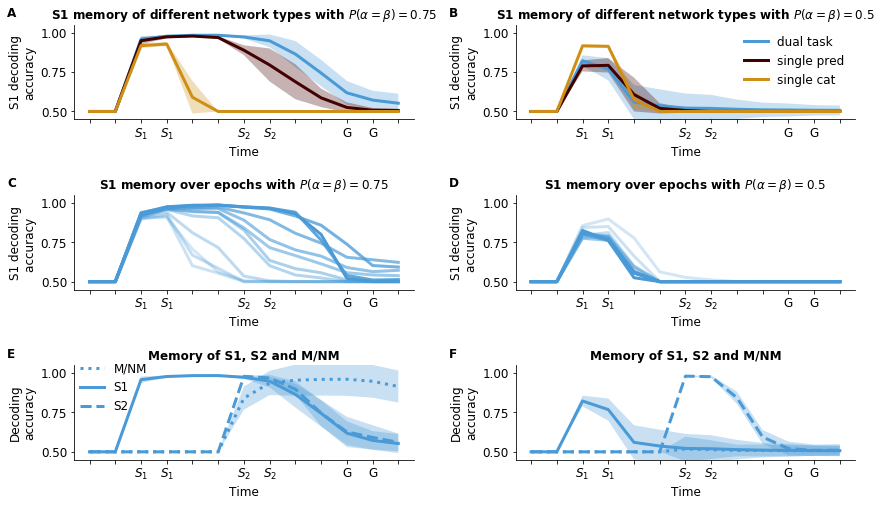

In [155]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8), gridspec_kw={'hspace': 0.8, 'wspace': 0.3})
prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/', ax=ax[0][0], plot_legend=False)
autotemp_dict = prm.plot_autotemp_s1_different_epochs(ax=ax[1][0], autotemp_dec_dict=autotemp_dict, plot_legend=False,
                                                     rnn_name='/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2134.data')


prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/', ax=ax[0][1], plot_legend=True)
autotemp_dict_50 = prm.plot_autotemp_s1_different_epochs(ax=ax[1][1], autotemp_dec_dict=autotemp_dict_50, plot_legend=False, 
                                                        rnn_name='/home/thijs/repos/rotation/models/save_state/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2252d.data')

prm.plot_autotemp_all_reps_decoding(reset_decoders=False, ax=ax[2][0],
                                    skip_if_already_decoded=True,
                                    rnn_folder='/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/')

prm.plot_autotemp_all_reps_decoding(reset_decoders=False, ax=ax[2][1],
                                    skip_if_already_decoded=True, plot_legend=False,
                                    rnn_folder='/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/')


ax[0][0].set_title('S1 memory of different network types with ' + r'$P(\alpha = \beta)=0.75$', fontdict={'weight': 'bold'})
ax[0][1].set_title('S1 memory of different network types with ' + r'$P(\alpha = \beta)=0.5$', fontdict={'weight': 'bold'})
ax[1][0].set_title('S1 memory over epochs with ' + r'$P(\alpha = \beta)=0.75$', fontdict={'weight': 'bold'})
ax[1][1].set_title('S1 memory over epochs with ' + r'$P(\alpha = \beta)=0.5$', fontdict={'weight': 'bold'});
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
i_let = 0
for i_row in range(3):
    for i_col in range(2):
        ax[i_row][i_col].text(s=letters[i_let], x=-3.2, y=1.1, fontdict={'weight': 'bold'})
        i_let += 1
# plt.savefig('figures/nips/fig4_mechanisms.pdf', bbox_inches='tight')

20it [00:00, 1197.31it/s]
20it [00:00, 1281.31it/s]
20it [00:00, 1298.16it/s]

s1
s2
go


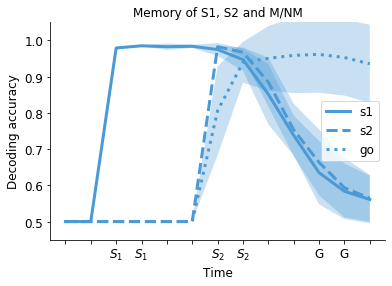

In [9]:
prm.plot_autotemp_all_reps_decoding(reset_decoders=False)

cpu


Text(1349.4827586206898, 0.5, 'dmc loss function')

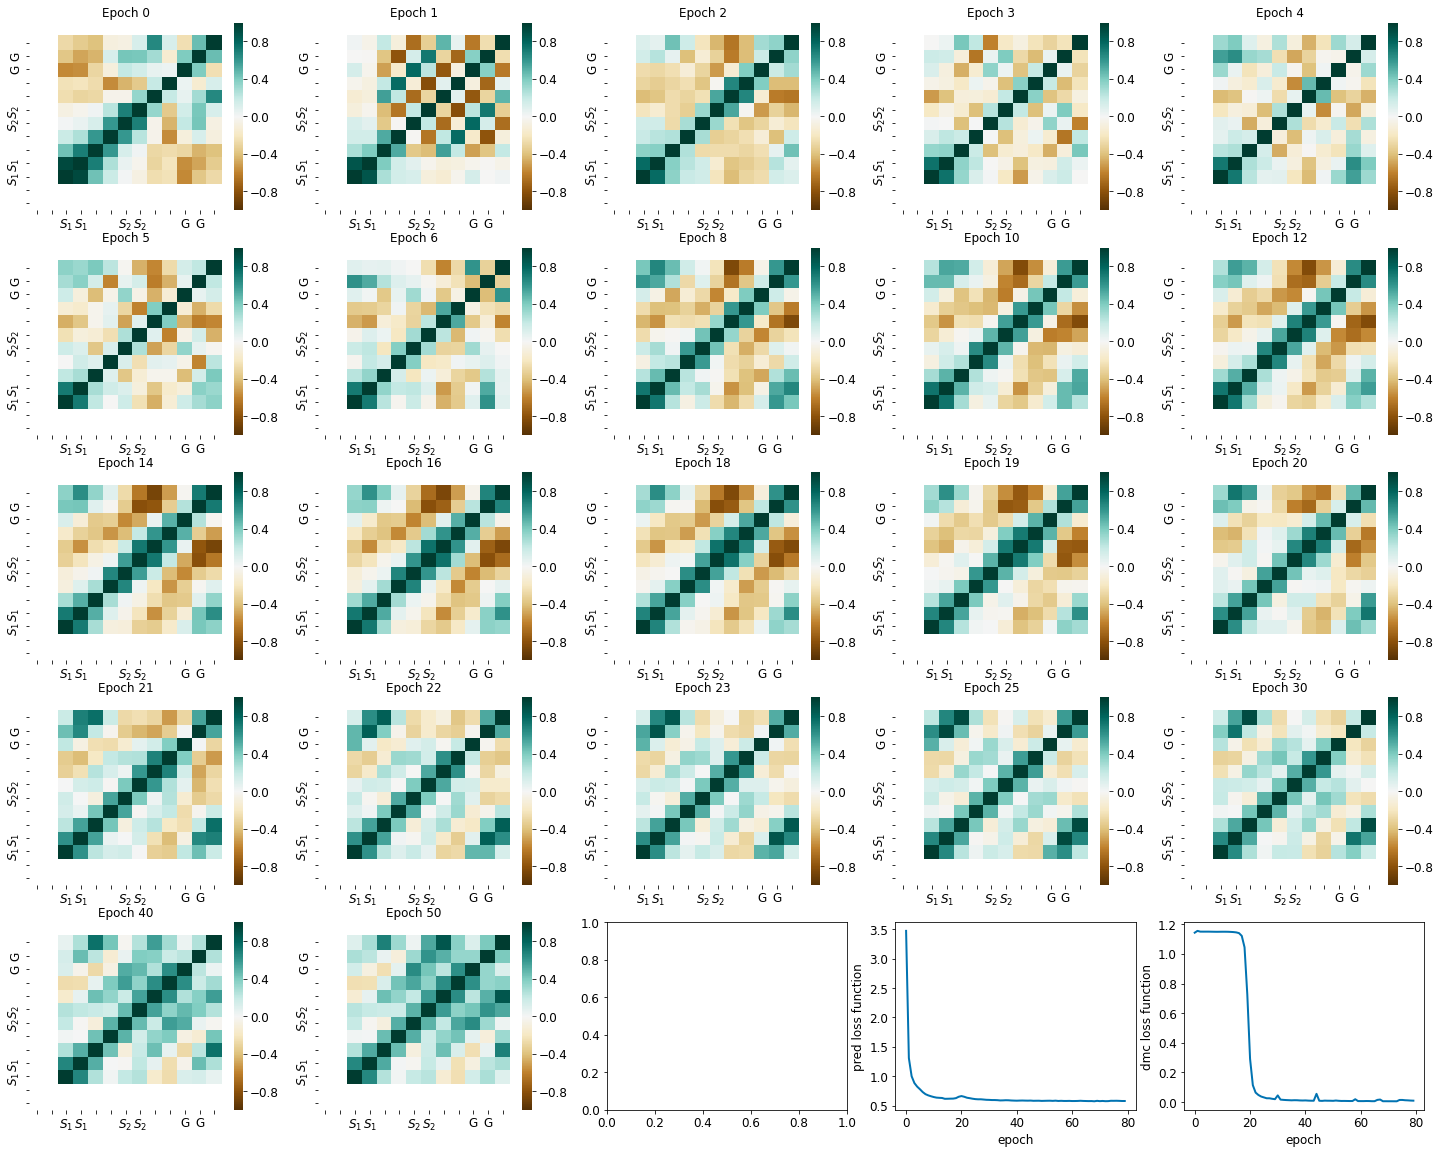

In [352]:
rnn = ru.load_rnn('/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2134.data')
rnn.eval()

fig, ax = plt.subplots(5, 5, figsize=(25, 20))

i_row, i_col = 0, 0
epoch_list = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25, 30, 40, 50]

for i_epoch, epoch in enumerate(epoch_list):
    rnn.load_state_dict(rnn.saved_states_dict[epoch])
    rnn.eval()
#     prm.plot_decoding_matrix(rnn=rnn, representation='s1', ax=ax[i_row][i_col])
    prm.plot_correlation_matrix(rnn=rnn, representation='s1', ax=ax[i_row][i_col], hard_reset=True)

    ax[i_row][i_col].set_title(f'Epoch {epoch}', y=0.75)
    ax[i_row][i_col].set_xlabel('')
    ax[i_row][i_col].set_ylabel('')
    
    i_col += 1
    if i_col == 5:
        i_row += 1
        i_col = 0
        

ax[4][3].plot(rnn.test_loss_split['pred'], linewidth=2)
ax[4][3].set_xlabel('epoch')
ax[4][3].set_ylabel('pred loss function')

        
ax[4][4].plot(rnn.test_loss_split['dmc'], linewidth=2)
ax[4][4].set_xlabel('epoch')
ax[4][4].set_ylabel('dmc loss function')


In [363]:
_, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                                 sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder


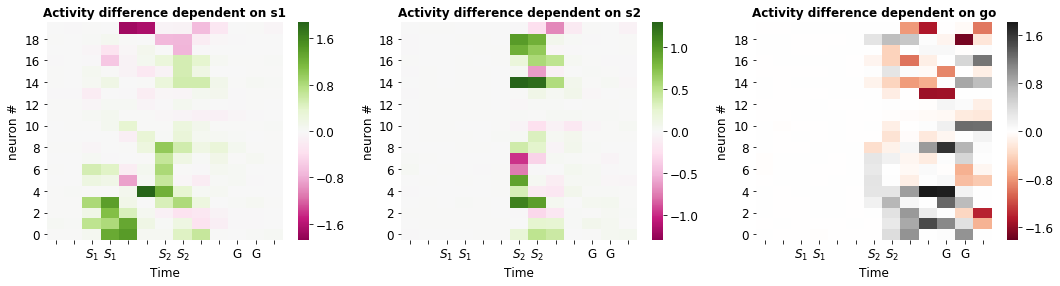

In [379]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

for ii, rep in enumerate(['s1', 's2', 'go']):
    plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation=rep)
    ol = prm.plot_raster_trial_average(plot_diff=plot_diff, ol=ol, ax=ax[ii], representation=rep)

In [396]:
rnn.test_loss_split.keys()

dict_keys(['pred', 'S2', 'G', 'G1', 'G2', '0', '0_postS1', '0_postS2', '0_postG', 'L1', 'dmc'])

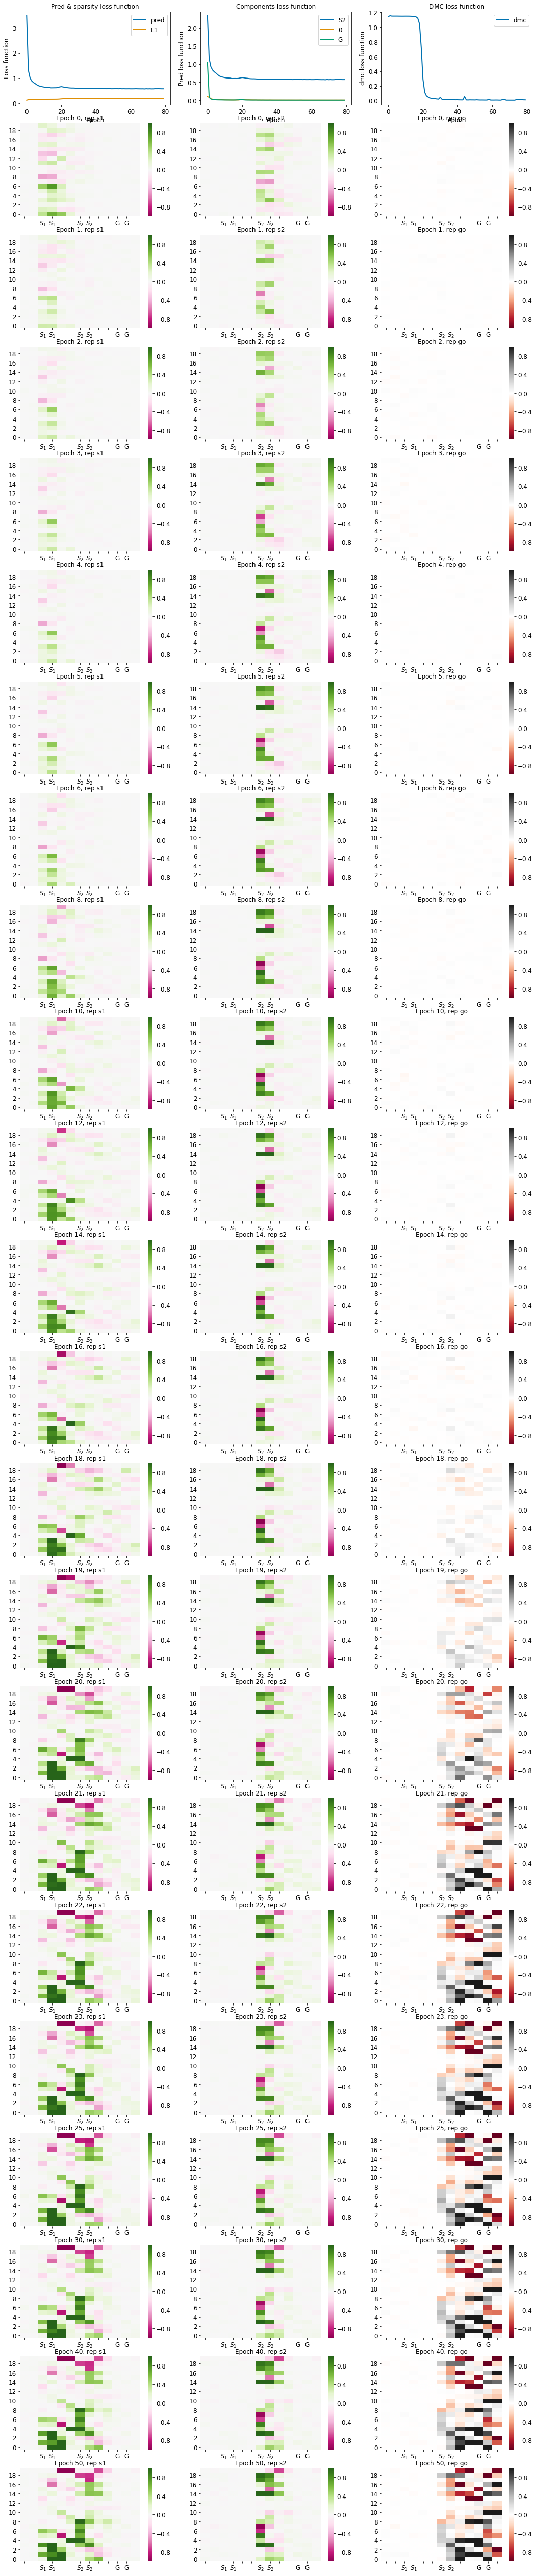

In [400]:
rnn = ru.load_rnn('/home/thijs/repos/rotation/models/save_state/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2134.data')
rnn.eval()

epoch_list = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25, 30, 40, 50]


fig, ax = plt.subplots(len(epoch_list) + 1, 3, figsize=(18, 4 * len(epoch_list) + 4))


for i_epoch, epoch in enumerate(epoch_list):
    rnn.load_state_dict(rnn.saved_states_dict[epoch])
    rnn.eval()
    _, __, forw  = bpm.train_single_decoder_new_data(rnn=rnn, ratio_expected=0.5,
                                                 sparsity_c=0.1, bool_train_decoder=False)  # just gets data without training decoder
    for ii, rep in enumerate(['s1', 's2', 'go']):
        plot_diff, _, __ = ru.calculate_diff_activity(forw=forw, representation=rep)
        ol = prm.plot_raster_trial_average(plot_diff=plot_diff, ol=ol, ax=ax[i_epoch + 1][ii], representation=rep,
                                           th=1)
    
        ax[i_epoch + 1][ii].set_title(f'Epoch {epoch}, rep {rep}', y=0.75)
        ax[i_epoch + 1][ii].set_xlabel('')
        ax[i_epoch + 1][ii].set_ylabel('')


ax[0][0].plot(rnn.test_loss_split['pred'], linewidth=2, label='pred')
ax[0][0].plot(rnn.test_loss_split['L1'], linewidth=2, label='L1')
ax[0][0].set_xlabel('epoch')
ax[0][0].set_ylabel('Loss function')
ax[0][0].set_title('Pred & sparsity loss function')
ax[0][0].legend()



ax[0][1].plot(rnn.test_loss_split['S2'], linewidth=2, label='S2')
ax[0][1].plot(rnn.test_loss_split['0'], linewidth=2, label='0')
ax[0][1].plot(rnn.test_loss_split['G'], linewidth=2, label='G')
ax[0][1].set_xlabel('epoch')
ax[0][1].set_ylabel('Pred loss function')
ax[0][1].set_title('Components loss function')
ax[0][1].legend()

        
ax[0][2].plot(rnn.test_loss_split['dmc'], linewidth=2, label='dmc')
ax[0][2].set_xlabel('epoch')
ax[0][2].set_ylabel('dmc loss function')
ax[0][2].set_title('DMC loss function')
ax[0][2].legend()

plt.savefig('figures/nips/rasters_per_epoch.pdf', bbox_inches='tight')


In [ ]:

fig, ax = plt.subplots(2, 2, figsize=(14, 5), gridspec_kw={'hspace': 0.8})
prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/7525/dmc_task/onehot/sparsity_1e-03/', ax=ax[0][0])
autotemp_dict = prm.plot_autotemp_s1_different_epochs(ax=ax[1][0], autotemp_dec_dict=autotemp_dict, plot_legend=False)


prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_1e-03/', ax=ax[0][1])
autotemp_dict_50 = prm.plot_autotemp_s1_different_epochs(ax=ax[1][1], autotemp_dec_dict=autotemp_dict_50, plot_legend=False, 
                                                        rnn_name='/home/thijs/repos/rotation/models/save_state/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-13-2252d.data')

ax[0][0].set_title('S1 memory of different network types with ' + r'$P(\alpha = \beta)=0.75$')
ax[0][1].set_title('S1 memory of different network types with ' + r'$P(\alpha = \beta)=0.5$')
ax[1][0].set_title('S1 memory over epochs with ' + r'$P(\alpha = \beta)=0.75$')
ax[1][1].set_title('S1 memory over epochs with ' + r'$P(\alpha = \beta)=0.5$');

plt.savefig('figures/nips/fig4_mechanisms.pdf', bbox_inches='tight')




20it [00:00, 1600.21it/s][A



20it [00:00, 887.25it/s]



20it [00:00, 1589.59it/s][A


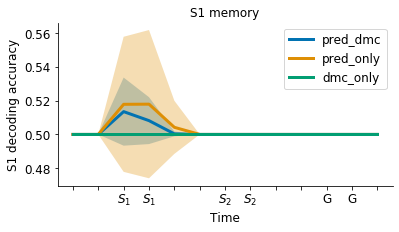

In [358]:
prm.plot_autotemp_s1_decoding('/home/thijs/repos/rotation/models/5050/dmc_task/onehot/sparsity_5e-03/')

In [4]:
rnn = ru.load_rnn('models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc/rnn-mnm_2021-05-11-1352d.data')

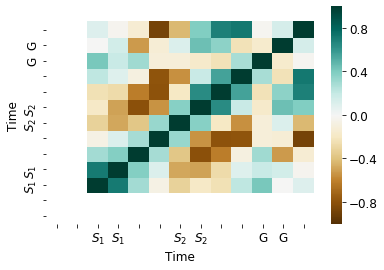

In [7]:
prm.plot_correlation_matrix(rnn=rnn, representation='s1')

In [33]:
# tmp = rnn.state_dict()
rnn.load_state_dict(rnn.state_dict())

<All keys matched successfully>

0.5223539068817646 0.006909553240984678
0.28748197519714846 0.005535509996116161
0.629822875798093 0.006735853757709265
-0.4462443389387311 0.007097237883135677
0.2998769632449888 0.005309921829029918
0.6110261234125272 0.005335417250171304
-0.1900302931667276 0.14100096747279167
0.3880387545080344 0.3522061914205551
0.41222625230668786 0.00573175479657948
-0.10560425551007431 0.0048860710114240645
0.06985487287994653 0.012358531914651394
0.321870672796507 0.005309921829029918
0.5646505467475035 0.005075516272336244
-0.35770766297096285 0.005296013318002224
0.4164479059567825 0.005711321486160159
0.5985339258450051 0.00949377384968102
-0.05962437388412361 1.3862946033477783
0.3819731365414677 0.3522061914205551
0.052703762617330945 0.007043668162077665
-0.39690485341253534 0.007612431887537241


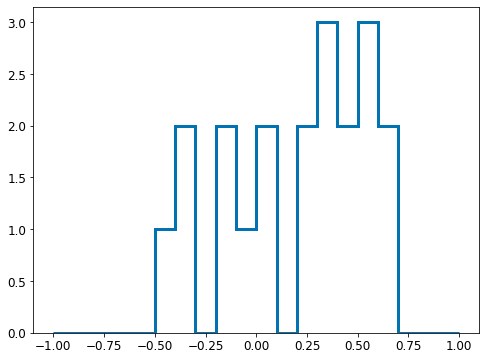

In [30]:
ax = plt.subplot(111)
# prm.plot_hist_rot_indices(rnn_folder='models/7525/dmc_task/onehot/sparsity_1e-03/pred_only', ax=ax)
# prm.plot_hist_rot_indices(rnn_folder='models/7525/dmc_task/onehot/sparsity_1e-03/dmc_only', ax=ax)
prm.plot_hist_rot_indices(rnn_folder='models/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc', ax=ax)

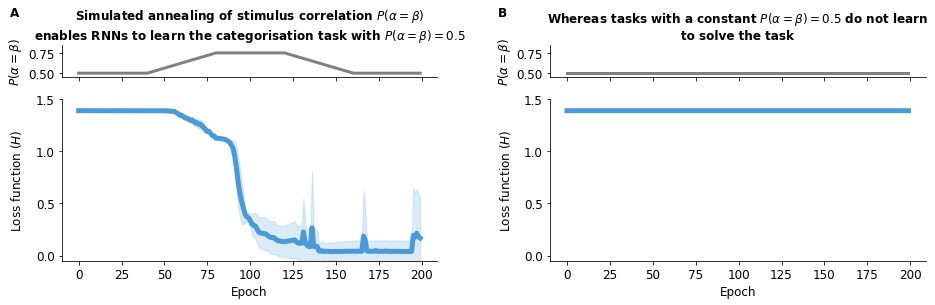

In [282]:
_ = prm.plot_sa_convergence(plot_indiv=False, sa_folder_list=['/home/thijs/repos/rotation/models/simulated_annealing/7525/dmc_task/onehot/sparsity_1e-03/pred_dmc', '/home/thijs/repos/rotation/models/simulated_annealing/5050/dmc_task/onehot/sparsity_1e-03/pred_dmc'])
plt.savefig('figures/nips/fig5-simulated-annealing.pdf', bbox_inches='tight')